# (Quasi) Stokes equations (Scipy based Uzawa scheme for Schur's complement)

## Schur's complement

The Quasi-Stokes equations in weak form (neglecting all boundary
conditions) read as

\begin{align*}
\int_\Omega \rho\,u\cdot v + \sigma(u,\,p):\varepsilon(v)\,\mathrm{d}x & = \int_\Omega f\,v,\,\mathrm{d}x \\
\int_\Omega \nabla\cdot u\,q\,\mathrm{d}x &= 0.
\end{align*}

on some given domain, where $u,\,v\in X$, $p,\,q\in Q$ with $X$ and
$Q$ appropriately chosen function spaces, $\sigma$, $\epsilon$
defined as in the Navier-Stokes intro slides.

\begin{align*}
\sigma(u, p)&=2\,\mu \epsilon (u) - p\,I,\\
\epsilon(u)&=\frac{1}{2}\left(\nabla u + (\nabla u)^T\right).
\end{align*}

These equations can paraphrased as operator equations of the form

\begin{align*}
A\,u + B\,p = F,\\
B^\ast u = 0
\end{align*}

with an operator $A:X \rightarrow X^\ast$, the "gradient operator"
$B:Q\rightarrow X^\ast$ and its adjoint, the "divergence operator"
$B^\ast:X\rightarrow Q^\ast$ and "right hand side" $F\in X^\ast$. We
now "virtually" solve the first equation for $u$ and substitute the
result into the second equation:

\begin{align*}
u = A^{-1}\,(F - B\,p),\\
- B^\ast A^{-1}\,(F - B\,p) = 0.
\end{align*}

This means, the pressure $p$ is the unique solution of the equation

\begin{align}
\hat T\,p = (B^\ast\,A^{-1}\,B)\,p = B^\ast\,A^{-1}\,F.
\end{align}

The velocity can then be computed from $p$ using the first
euqation. The operator $\hat T=B^\ast\,A^{-1}\,B$ is the *Schur's
complement operator* for this saddle-point problem.

As $A$ is symmetric positive definite it is clear that $\hat T$ is
also symmetric. It is also positive definite from other
reasoning. Hence it is possible to apply the PCG-method to Schur's
complement $\hat T$. For saddle point problems one uses a flavour of
the CG-method called "Uzawa-method" which constructs not only the
pressure $p$ during the iteration but also the principal unknown $u$.

## Domain and Range of Schur's complement

$\hat T$ as defined above is in principle an operator $\hat T:Q
\rightarrow Q^\ast$ as $B^\ast:X\rightarrow Q^\ast$. It holds that
it is spg w.r.t. to the componentwise scalar product of the
DOF-vectors. However, we want to implement our Uzawa-method over the
pressure space $Q$ equipped with its standard $L^2$ scalar
product. In order to do so we need in addition to the definition of
$\hat T$ above one additional $L^2$-projection which maps the range
of $\hat T:Q\rightarrow Q^\ast$ back to $Q$. So the operator that we
use in the Uzawa-method which is to be implemented below is defined by

$$
p\in Q:(T\,p,\,q)_Q = \langle B^\ast\,A^{-1}\,B\,p,\,q\rangle,\text{ for all }q\in Q.
$$

## Preconditioner

From the *strong* form of the Quasi-Stokes equations it is possible
to derive a precoditioner for Schur's complement as follows. With a lot of
"handwaving" the operator $A$ applied to a velocity $u$ is
"something" like $\rho\,u - \mu\,\nabla\cdot\nabla u$, while $B$
corresponds to the gradient $\nabla$ of a pressure function and
$B^\ast$ corresponds to the divergence of a velocity function. In
a very vague sense we have for given $q\in Q^\ast$:

\begin{align*}
\hat T^{-1}\,q &= (B^\ast\,A^{-1}\,B)^{-1}\,q\\
               &= B^{-1}\,A\,B^{-\ast}\,q\\
               &= \nabla^{-1}(\rho\dots - \mu\,\nabla\cdot\nabla\dots)\,(\nabla\cdot)^{-1}\,q\\
               &= \rho\,(\nabla\cdot\nabla)^{-1}\,q - \mu\,q.
\end{align*}

Mathematically, above line is horribly broken, however one can make
sense of it in terms of suitably chosen pseudo-inverses. If we
accept it, then a suitable preconditioner for $T$ is given by ($r\in Q$)

\begin{align*}
C^{-1}\,r &= \mu\,r + \rho\,\phi_r,
\end{align*}

where $\phi_r$ is the solution of Poisson's problem (in the pressure space)

\begin{align*}
-\Delta\,\phi_r &= r \text{ in }\Omega,\\
\partial_n\phi_r & =0 \text{ on }\partial\Omega
\end{align*}

where we assume no-slip boundary condition on the entire boundary. If
instead we impose stress-boundary conditions on parts of the
boundary then on those parts the boundary condition for this
subproblem has to be replaced by a homogeneous Robin boundary
condition with a penalty proportioanl to the inverse of the
mesh-size.

## Implementation Notes

- $T$ contains the inverse of $A$, so it is not feasible to assemble
  $T$. Instead, we have to exploit the fact that the Uzawa-method only
  uses $T$ to compute matrix-vector products. So for $p\in\,Q$ given
  in order to compute $r:=T\,p$ we perform the following steps:

  - $b:=B\,p$
  - solve $A\,x = b$ for $x$
  - $r^\ast:=B^\ast\,x$
  - solve $M_Q\,r = r^\ast$ for $r$ where $M_Q$ denotes the mass matrix in $Q$

- in the Uzawa-method we have to evaluate $T\,d^m$ (see Uzawa-slides)
  several times which implies we have to solve an equation with
  system matrix $A$ several times. Of course, we model $A$ by a
  suitable UFL-form and Dune-Fem scheme or
  `dune.fem.operator.galerkin`, but if we would just call
  `scheme.solve(...)` then this would each time assemble $A$ and
  then solve. We can avoid the repeated assembling of always the
  same matrix by using the `linear(...)` method of the scheme and
  then solve with that pre-assembled matrix.

- Likewise, the matrices for $B$ and $B^\ast$ can be assembled
  outside of the Uzawa-method.

- In order to use preassembled operators in the context of Dirichlet
  boundary conditions it is necessary to use the method
  `OPERATOR.setConstraints(...)`. This can be found on the slides of
  the talk about solvers.

- Please note that we have to apply the
  inhomogeneous Dirichlet conditions on the velocity in the setup
  section of the Uzawa-scheme and later during the iteration we have
  to impose *homogeneous* Dirichlet conditions as there only updates
  are computed which otherwise would spoil the already settled
  Dirichlet values.

- Our solution of this assignment uses `scipy.sparse` and
  `numpy`. However, this is not strictly required.

- It would be a nice extencsion to implement this method in the
  context of domain decomposition. This would require to add
  communication statements at the proper places and rather use the
  linear algebra methods (like `scalarProductDofs(...)`) from Dune
  than from scipy.


In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.sparse import bmat, linalg
from dune.grid import cartesianDomain
from dune.alugrid import aluCubeGrid
from dune.fem.space import lagrange, dgonb
from dune.fem.operator import galerkin as galerkinOperator
from ufl import SpatialCoordinate, CellVolume, TrialFunction, TestFunction,\
                inner, dot, div, grad, dx, as_vector, transpose, Identity, nabla_grad
from dune.ufl import Constant, DirichletBC
import dune.fem

rhoValue = 1
muValue = 0.1


order = 2

# feel free to replace this with you favourite FE-mesh
grid = aluCubeGrid(constructor=cartesianDomain([0,0],[3,1],[30,10]))
spcU = lagrange(grid, dimRange=grid.dimension, order=order, storage="numpy")
spcP = lagrange(grid, order=order-1, storage="numpy")

x     = SpatialCoordinate(spcU)
rho   = Constant(rhoValue, "rho")
mu    = Constant(muValue, "mu")
u     = TrialFunction(spcU)
v     = TestFunction(spcU)
p     = TrialFunction(spcP)
q     = TestFunction(spcP)

exact_u     = as_vector( [x[1] * (1.-x[1]), 0])
exact_p     = (-2*x[0] + 2)*rho
f           = as_vector( [0,]*grid.dimension)
f          += mu*exact_u
dbc = DirichletBC(spcU, exact_u)

## Task: define the models and operators
I.e. define the UFL form and generate a couple of
`galerkinOperator`s for all needed parts.

In [17]:
##### TASK

In [18]:
A_model = rho * dot(u,v) * dx + mu * inner(grad(u) + grad(u).T, grad(v)) * dx - dot(f,v) * dx
grad_Model = -inner(p*Identity(grid.dimension), grad(v)) * dx
B_model = - inner(q, div(u)) * dx
precondition_model = inner(grad(p), grad(q)) * dx
mass_model = p * q * dx


## Task: assemble the matrices

##### TASK
b-model is div -model

B = D

In [19]:
A_op = galerkinOperator([A_model, dbc])
grad_operator = galerkinOperator([grad_Model, dbc])
B_op = galerkinOperator(B_model)
precondition_op = galerkinOperator((precondition_model, DirichletBC(spcP, 0)),spcP)
mass_op = galerkinOperator(mass_model)

A = A_op.linear()
A = A.as_numpy
G = grad_operator.linear()
G = G.as_numpy
B = B_op.linear()
B = B.as_numpy
precondition = precondition_op.linear()
precondition = precondition.as_numpy
mass_op = mass_op.linear()
mass_op = mass_op.as_numpy

## Task: compute the "right hand side" for Schur's complement operator

In [29]:
##### TASK
velocity = spcU.interpolate([0,0], name = "velocity")
pressure = spcP.interpolate(0, name = "pressure")
sol_u = velocity.as_numpy
sol_p = pressure.as_numpy

rhsVelo  = velocity.copy()
rhsPress = pressure.copy()
rhs_u  = rhsVelo.as_numpy
rhs_p  = rhsPress.as_numpy
r      = np.zeros_like(rhs_p)
precon = np.zeros_like(rhs_p)
chi = np.zeros_like(rhs_u)

DUNE-INFO: UFLLocalFunction (rebuilding)


In [30]:
A_op(velocity, rhsVelo) # für randwerte
# rhsVelo.plot()
rhs_u *= -1
A_op.setConstraints(rhsVelo)
sol_u[:] = linalg.spsolve(A, rhs_u) #u = A^-1 * (F-B*p) // but p= 0 //  3.99a
rhs_p[:] = B * sol_u # 3.99b, rhs_p = B*u
r = linalg.spsolve(mass_op, rhs_p) # 3.99b, M * r = rhs_p
precon[:] = linalg.spsolve(precondition, rhs_p) # 3.99c, P * precon = rhs_p
r[:]= mu*r + precon * rho # 3.99d r = mu * r + rho * precon
d = np.copy(r) # 3.99e, d = r
delta = np.dot(r,rhs_p) # 3.99f, delta = mass * r * mass^-1 *rhs_p
print(delta)


0.011326755394026947


## Task: implement the initialization step of the Uzawa iteration

## Task: implement the Uzawa iteration

In [22]:
##### TASK


In [31]:
iterations = 0

while delta > 1e-18 and iterations < 1000:
    rhs_u[:] = G * d # 3.99g, rhs_u = G * d
    chi[:] = linalg.spsolve(A, rhs_u) # 3.99g, chi = A^-1 * rhs_u
    rhs_p[:] = B * chi # wie oben 3.99b
    scale = - delta/np.dot(d, rhs_p) # 3.99h, rho = - delta / (d * B * chi)
    sol_p -= scale * d # 3.99i, p = p - rho * d
    sol_u += scale * chi # 3.99i, u = u + rho * chi
    rhs_p[:] = B * sol_u # wie oben 3.99b
    r = linalg.spsolve(mass_op, rhs_p) # 3.99k // wie oben 3.99b
    precon[:] = linalg.spsolve(precondition, rhs_p) # 3.99k // wie oben 3.99c
    r[:] = mu*r + precon * rho # wie oben 3.99d
    delta_new = np.dot(r, rhs_p) # 3.99n, delta_new = r * M * r
    gamma = delta_new / delta # 3.99o, gamma = delta_new / delta
    delta = delta_new
    d[:] = r + gamma * d # 3.99p, d = r + gamma * d
    print(f"error at iteration {iterations}: {delta}")
    iterations += 1

error at iteration 0: 0.010095833011726632
error at iteration 1: 0.002039221905830251
error at iteration 2: 0.000182102314615501
error at iteration 3: 1.0152260986908151e-05
error at iteration 4: 9.92368606837587e-07
error at iteration 5: 1.2851793874677606e-07
error at iteration 6: 1.893389655251587e-08
error at iteration 7: 6.978605586808165e-09
error at iteration 8: 4.4260407729570694e-09
error at iteration 9: 3.9391198183927437e-10
error at iteration 10: 3.556071630608538e-12
error at iteration 11: 1.5173426260779703e-13
error at iteration 12: 2.7405645089851606e-14
error at iteration 13: 1.6487713786615873e-14
error at iteration 14: 6.164007413698968e-15
error at iteration 15: 2.454985951349429e-16
error at iteration 16: 9.56125843568746e-18
error at iteration 17: 1.45538015713028e-19


Now we can easily plot the velocity magnitude and pressure

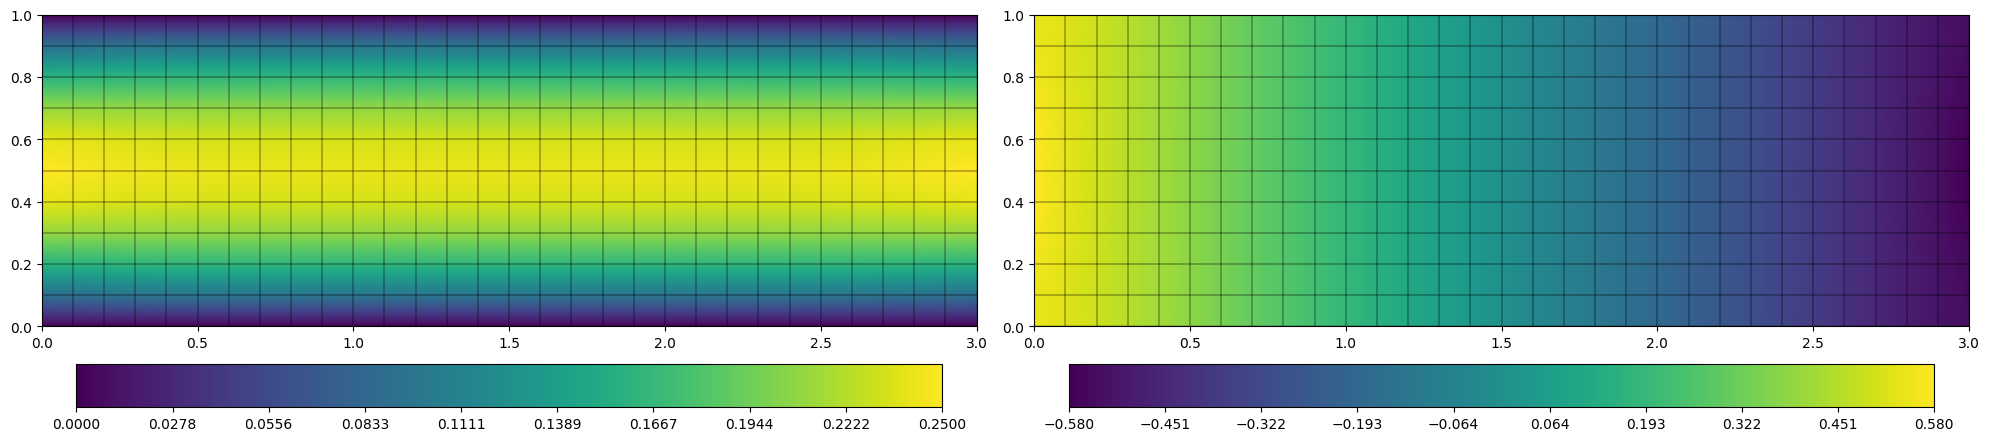

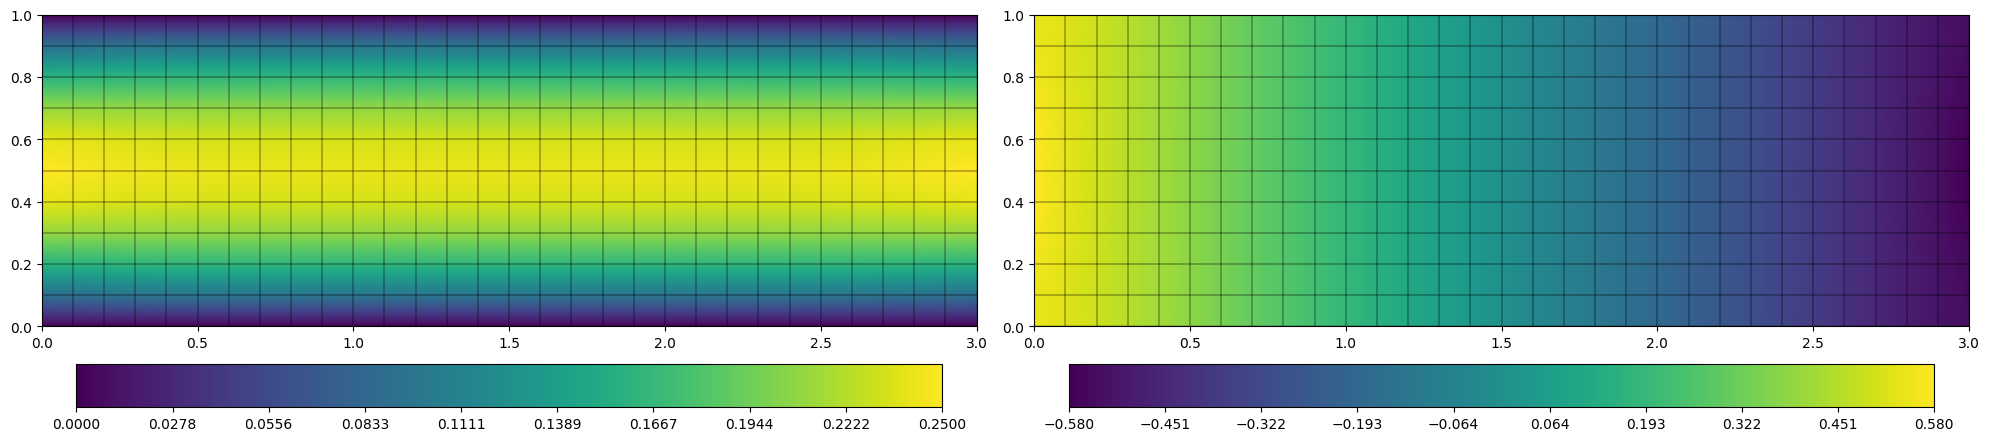

In [28]:
fig = plt.figure(figsize=(20,10))
velocity.plot(colorbar="horizontal", figure=(fig, 121))
pressure.plot(colorbar="horizontal", figure=(fig, 122))

A_op(velocity,rhsVelo)
rhs_u *= -1
chi[:] = G*sol_p
rhs_u -= chi
A_op.setConstraints(rhsVelo)
sol_u = linalg.spsolve(A, rhs_u)

fig = plt.figure(figsize=(20,10))
velocity.plot(colorbar="horizontal", figure=(fig, 121))
pressure.plot(colorbar="horizontal", figure=(fig, 122))

#

## Task: implement a parallel version of the algorithm

It is probably a good idea to do this in a copy of this file and to
not append it here.